In [1]:
import os
import math
import warnings
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement, qLogExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine
from torch import Tensor

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
# SMOKE_TEST = os.environ.get("SMOKE_TEST")

/usr/anaconda3/envs/botorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import mpcc
import numpy as np
from math import pi

param_dim = 9
batch_size = 50
n_init = 5 * param_dim
max_cholesky_size = float("inf")  # Always use Cholesky


qC_bound                   = [100.0, 500.0]
qCNmult_bound              = [10.0, 100.]
qL_bound                   = [100.0 ,500.0]
qVs_bound                  = [1.0, 10.0]
qOri_bound                 = [5.0, 20.0]
qC_reduction_ratio_bound   = [0.001, 0.2]
qL_increase_ratio_bound    = [1.0, 4.0]
qOri_reduction_ratio_bound = [0.5, 1.0]
qSelCol_bound              = [0.001, 1.0] 

def unnoramlize(normalized_x: float, bound: list) -> float:
    return normalized_x * (bound[1] - bound[0]) + bound[0]

def eval_objective(param_value_tensor: Tensor) -> Tensor:
    integrator = mpcc.Integrator()
    robot = mpcc.RobotModel()
    robot_dof = robot.num_q
    mpc = mpcc.MPCC()

    state = np.array([0., 0., 0., -pi/2, 0., pi/2, pi/4, 0., 0.])
    mpc.setTrack(state)
    spline_pos, spline_ori, spline_arc_length = mpc.getSplinePath()

    param_value = {"cost": {"qC" : unnoramlize(param_value_tensor[0].item(),qC_bound),
                            "qCNmult": unnoramlize(param_value_tensor[1].item(),qCNmult_bound),
                            "qL": unnoramlize(param_value_tensor[2].item(),qL_bound),
                            "qVs": unnoramlize(param_value_tensor[3].item(),qVs_bound),
                            "qOri": unnoramlize(param_value_tensor[4].item(),qOri_bound),
                            "qC_reduction_ratio": unnoramlize(param_value_tensor[5].item(),qC_reduction_ratio_bound),
                            "qL_increase_ratio": unnoramlize(param_value_tensor[6].item(),qL_increase_ratio_bound),
                            "qOri_reduction_ratio": unnoramlize(param_value_tensor[7].item(),qOri_reduction_ratio_bound),
                            }}
    mpc.setParam(param_value)

    is_reached = False
    total_contour_error = 0

    for time_idx in range(3000):
        status, state, opt_input, _, _ = mpc.runMPC(state)
        if status == False:
            is_reached = False
            break
        state = integrator.simTimeStep(state, opt_input)

        ee_pos = robot.getEEPosition(state[:robot_dof])
        ee_ori = robot.getEEOrientation(state[:robot_dof])
        ref_pos, _ = mpc.getRefPose(state[-2])

        total_contour_error += np.linalg.norm(ref_pos - ee_pos)

        if np.linalg.norm((spline_pos[-1] - ee_pos), 2) < 1E-2 and np.linalg.norm(mpcc.Log(spline_ori[-1].T @ ee_ori), 2) and abs(state[-2] - spline_arc_length[-1]) < 1E-2:
            is_reached = True
            break

    reward = -time_idx-10*total_contour_error if is_reached else -10000

    print("reward: ", reward)

    return Tensor([reward])

In [3]:
@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 10  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

In [4]:
state = TurboState(dim=param_dim, batch_size=batch_size)
print(state)

TurboState(dim=9, batch_size=50, length=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, failure_tolerance=1, success_counter=0, success_tolerance=10, best_value=-inf, restart_triggered=False)


In [5]:
def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

In [6]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, train_Y.max())
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

In [7]:
X_turbo = get_initial_points(param_dim, n_init)
Y_turbo = torch.tensor(
    [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
).unsqueeze(-1)

state = TurboState(param_dim, batch_size=batch_size, best_value=max(Y_turbo).item())

NUM_RESTARTS = 10 # if not SMOKE_TEST else 2
RAW_SAMPLES = 512 # if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * param_dim)) # if not SMOKE_TEST else 4

torch.manual_seed(0)

best_value_so_far = -float("inf")
best_params = None

while not state.restart_triggered:  # Run until TuRBO converges
    # Fit a GP model
    train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(
            nu=2.5, ard_num_dims=param_dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )
    model = SingleTaskGP(
        X_turbo, train_Y, covar_module=covar_module, likelihood=likelihood
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Do the fitting and acquisition function optimization inside the Cholesky context
    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        # Fit the model
        fit_gpytorch_mll(mll)

        # Create a batch
        X_next = generate_batch(
            state=state,
            model=model,
            X=X_turbo,
            Y=train_Y,
            batch_size=batch_size,
            n_candidates=N_CANDIDATES,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf="ts",
        )

    Y_next = torch.tensor(
        [eval_objective(x) for x in X_next], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Update state
    state = update_state(state=state, Y_next=Y_next)

    # Append data
    X_turbo = torch.cat((X_turbo, X_next), dim=0)
    Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)

    # Update best value and corresponding parameters
    if state.best_value > best_value_so_far:
        best_value_so_far = state.best_value
        best_params = X_turbo[Y_turbo.argmax()]  # Assuming X_turbo is a list of parameter configurations

    # Print current status
    print(
        f"{len(X_turbo)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
    )

Franka Panda Robot Model is loaded!
Franka Panda Robot Model is loaded!
Franka Panda Robot Model is loaded!
Default initialization of model params
bounds initialized
Franka Panda Robot Model is loaded!
Default initialization of model params
bounds initialized
param values:
cost values:
	qC: 290.043
	qCNmult: 63.3272
	qC_reduction_ratio: 0.0175771
	qL: 297.792
	qL_increase_ratio: 1.29629
	qOri: 19.3414
	qOri_reduction_ratio: 0.673733
	qVs: 3.82467
bounds values:
normalization values:
sqp values:
generate new initial guess!!
================ QP did not solved ================
============== SQP Max Iter reached ===============
generate new initial guess!!
================ QP did not solved ================
============== SQP Max Iter reached ===============
generate new initial guess!!
================ QP did not solved ================
============== SQP Max Iter reached ===============
generate new initial guess!!
================ QP did not solved ================
============== SQP M

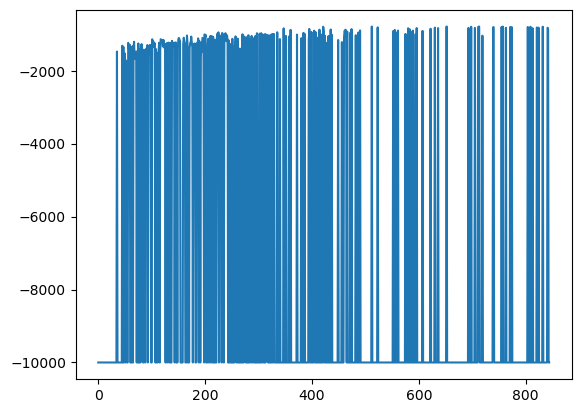

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

%matplotlib inline

plt.plot(Y_turbo.cpu())


In [9]:
print(f"Best objective value found: {best_value_so_far:.2e}")
print(f"Optimal parameters: {best_params}")

Best objective value found: -7.86e+02
Optimal parameters: tensor([0.5879, 0.0348, 0.9699, 0.4753, 0.6281, 0.0601, 0.4677, 0.1708, 0.2986],
       dtype=torch.float64)


In [10]:
best_param_value = {"cost": {"qC" : unnoramlize(best_params[0].item(),qC_bound),
                            "qCNmult": unnoramlize(best_params[1].item(),qCNmult_bound),
                            "qL": unnoramlize(best_params[2].item(),qL_bound),
                            "qVs": unnoramlize(best_params[3].item(),qVs_bound),
                            "qOri": unnoramlize(best_params[4].item(),qOri_bound),
                            # "rdq": unnoramlize(best_params[5].item(),rdq_bound),
                            # "rdVs": unnoramlize(best_params[6].item(),rdVs_bound),
                            # "rVee": unnoramlize(best_params[7].item(),rVee_bound),
                            "qC_reduction_ratio": unnoramlize(best_params[5].item(),qC_reduction_ratio_bound),
                            "qL_increase_ratio": unnoramlize(best_params[6].item(),qL_increase_ratio_bound),
                            "qOri_reduction_ratio": unnoramlize(best_params[7].item(),qOri_reduction_ratio_bound)
                            }} 
print(best_param_value)

{'cost': {'qC': 335.1775943905013, 'qCNmult': 13.128803746630386, 'qL': 487.9634130422821, 'qVs': 5.277659582693945, 'qOri': 14.42138201877284, 'qC_reduction_ratio': 0.012964724531432156, 'qL_increase_ratio': 2.403147164254986, 'qOri_reduction_ratio': 0.5854150648099892}}
